Given a biased coin of unknown bias, can you generate fair random bits? Given such a coin, can you generate random bits with a desired bias? Given a random source of numbers chosen independently and uniformly from $ [0, 1] $, can you generate numbers according to a normal random variable?

This chapter will focus on answering such questions, providing a range of methods varying in simplicity and efficiency.

One can easily discard this chapter without affecting the understanding the rest of the lecture notes, although some of the ideas first discussed in chapter might be helpful in the following chapters.

## Biasing and Unbiasing Coins
We are discussing this subject here, not because it is of use to us, but because the ideas are simple, yet inherently beautiful, and it is related to our subject in its spirit.

### Unbiasing
Here, we will start with the following question:
> Given a biased coin, emulate a fair one!

The idea we will discuss is usually attributed to John von Neumann: throw your coin twice, count "heads then tails" as heads, and "tails then heads" as tails. Repeat on the other two cases!

The two events have probability $ \mathbb{P}(HT \vert \{HT, TH)\} = \mathbb{P}(TH \vert \{HT, TH)\}) = \frac{p(1-p)}{2p(1-p)} = \frac{1}{2} $.

Let's demonstrate the simple process:

(array([ 500.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  500.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

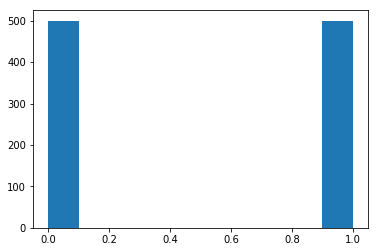

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

bias = 0.7
nSim = 1000

throws = np.zeros(nSim)
for i in range(nSim):
    while True:
        x = 1 if np.random.random() > bias else 0
        y = 1 if np.random.random() > bias else 0
        if x != y:
            throws[i] = x
            break
    
plt.hist(throws, bins=)

The above process takes $ \frac{1}{p(1-p)} $ throws of the coin to obtain a single bit.

### Biasing
Now, we turn to the opposite problem! Can you build a coin of a given bias? Even an irrational bias? We can of course assume we have a fair coin, since we now know how to unbias it.

> Can you emulate a coin of bias $\frac{1}{\pi}$?

For a given number $ p \in [0, 1] $, write down the binary expansion of $p$. It is obvious that $p = \sum_{i=1}^{\infty} b_i (\frac{1}{2})^i $, where $b_i$s are the numbers in the binary expansion of $p$.

How can that help? We can simulate events of probability $2^{-i}$ using our coin. Just throw the fair coin until the first "heads" comes up! The probability that the process takes $i$ steps is exactly $2^{-i}$. If the first head comes up at $i$th position, return heads if $b_i$ is 1, and return tails otherwise.

The probability of returning heads is by definition $ \sum_{i=1}^{\infty} b_i 2^{-i} = p $.